In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [5]:
DATA_DIR = Path('data/cactus')
TEMP_DIR = Path('temp/cactus')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [11]:
#!kaggle competitions download -c aerial-cactus-identification -p {str(DATA_DIR)}

In [9]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [10]:
df.head(10)

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [11]:
df.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.6+ KB


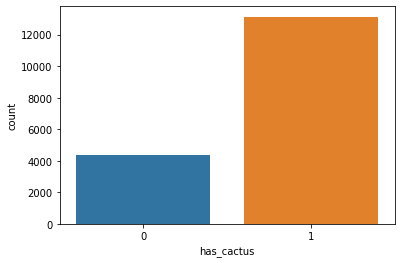

In [13]:
sns.countplot(x='has_cactus', data=df)

Data unevenly distributed. We will need to mitigate that.

In [14]:
IMG_DIMS = (71, 71, 3)
df['paths'] = df['id'].apply(lambda image_id: str(DATA_DIR/'train'/image_id))

In [15]:
train_data, validation_data = train_test_split(df, test_size=0.2)

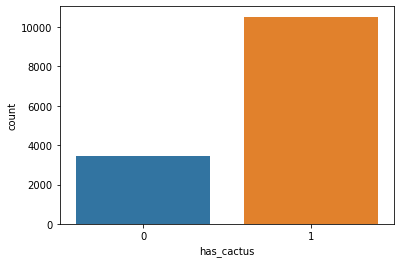

In [16]:
sns.countplot(x='has_cactus', data=train_data)

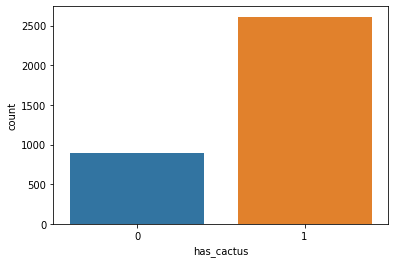

In [17]:
sns.countplot(x='has_cactus', data=validation_data)

In [18]:
test_data = pd.read_csv(DATA_DIR/'sample_submission.csv', low_memory=False)
test_data['paths'] = test_data['id'].apply(lambda image_id: str(DATA_DIR/'test'/image_id)) 

In [26]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    parallel_calls=1,
    batch_size=32,
    prefetch=1,
    preprocess_pipeline=[
        ImageParser()
    ],
)

data_container = DataContainer(
    train=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageRandomCropTransformation(IMG_DIMS, crop_adjustment=1.0)
        ],
        shuffle=True,
    )).build_from_df(train_data, 'paths', 'has_cactus'),
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageCropTransformation(IMG_DIMS),
        ],
    )).build_from_df(validation_data, 'paths', 'has_cactus'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'paths', 'has_cactus'),
)

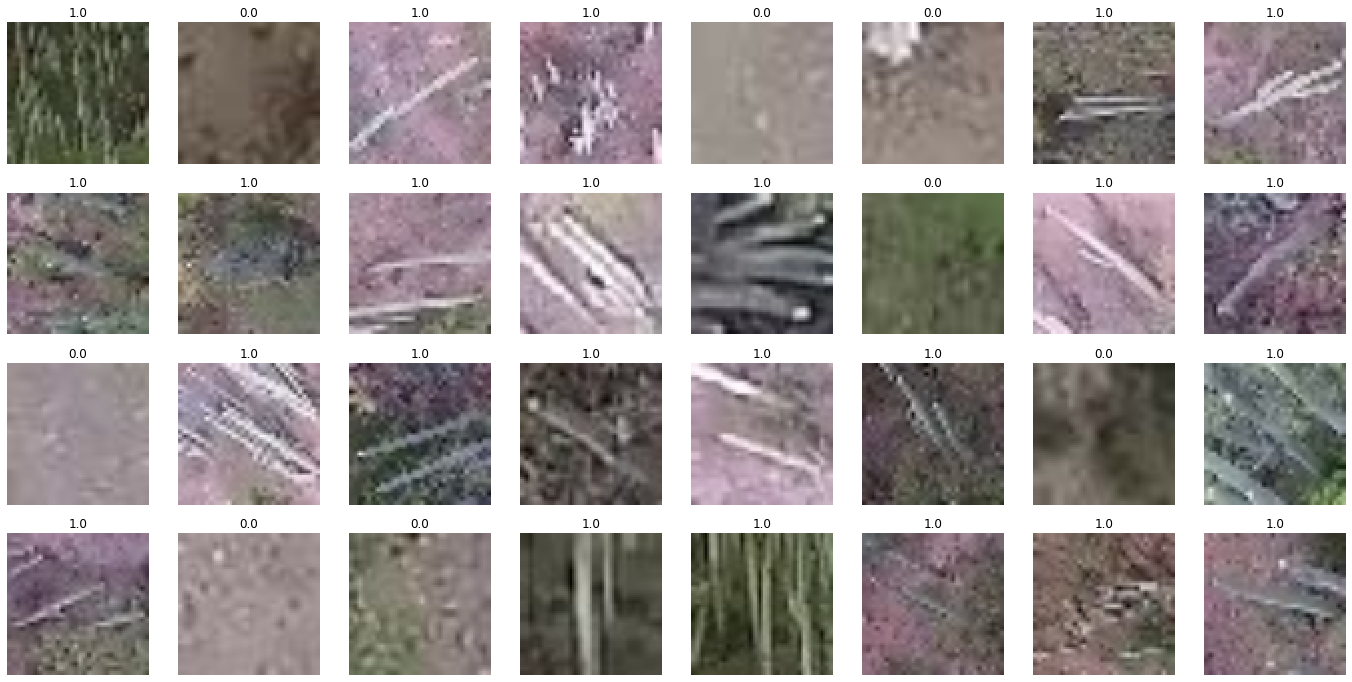

In [27]:
data_container.train.show()

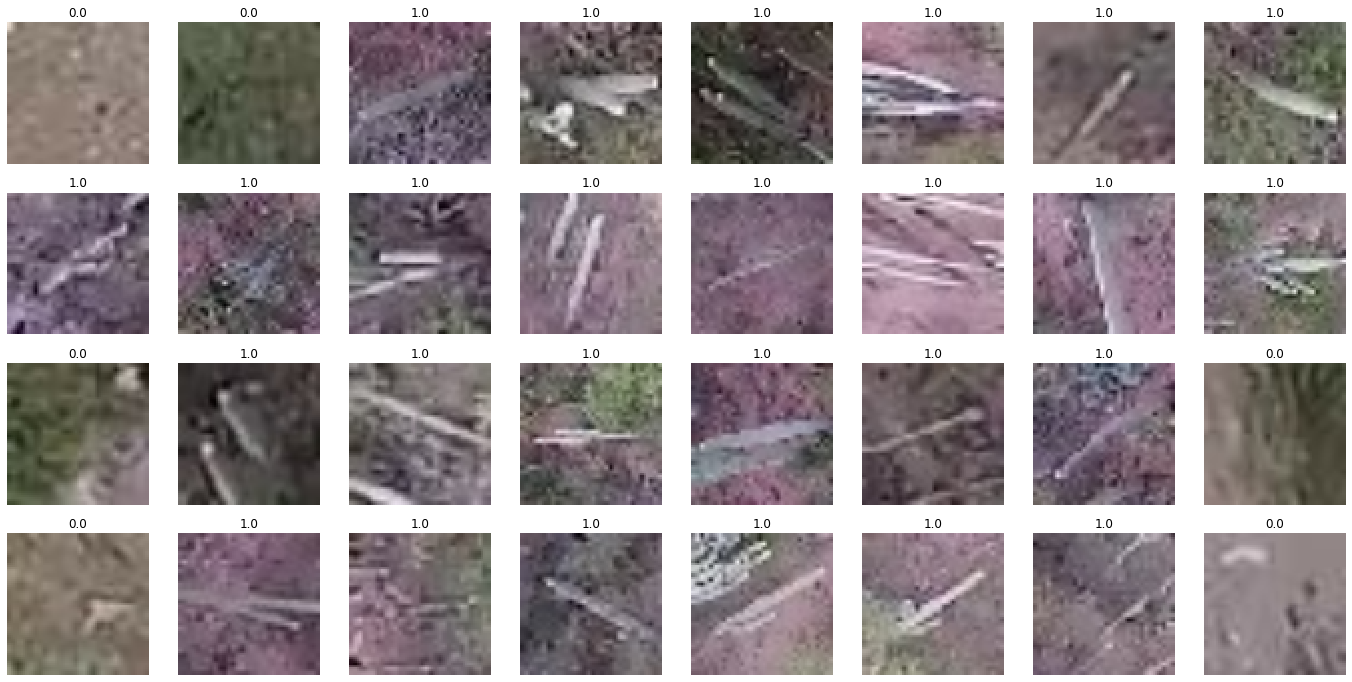

In [28]:
data_container.validation.show()

In [29]:
learner = ImageLearner(
    path=DATA_DIR,
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    dropout=0.3
)

In [30]:
learner.auto_train(
    easing_epochs=5,
    epochs=15,
    optimizer=keras.optimizers.Adam,
    lr=1e-3,
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy]
)

Freezing all except last model layers
Training frozen model
Epoch 1/5
438/438 [==============================] - 17s 38ms/step - loss: 0.3079 - binary_accuracy: 0.8837 - val_loss: 0.3608 - val_binary_accuracy: 0.8304
Epoch 2/5
438/438 [==============================] - 13s 30ms/step - loss: 0.2465 - binary_accuracy: 0.9230 - val_loss: 0.3585 - val_binary_accuracy: 0.8361
Epoch 3/5
438/438 [==============================] - 13s 30ms/step - loss: 0.2286 - binary_accuracy: 0.9284 - val_loss: 0.3709 - val_binary_accuracy: 0.8461
Epoch 4/5
438/438 [==============================] - 13s 30ms/step - loss: 0.2242 - binary_accuracy: 0.9292 - val_loss: 0.3588 - val_binary_accuracy: 0.8607
Epoch 5/5
438/438 [==============================] - 13s 30ms/step - loss: 0.2091 - binary_accuracy: 0.9317 - val_loss: 0.3319 - val_binary_accuracy: 0.8587
Unfreezing all layers
Finished training frozen model
Starting model training
Epoch 1/15
438/438 [==============================] - 72s 164ms/step - loss: 0

In [31]:
h = pd.DataFrame(learner.history.history); h

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.092118,0.968286,1.134800,0.920000,0.0010
1,0.061299,0.983679,0.032169,0.987571,0.0010
2,0.043233,0.986750,0.025081,0.991571,0.0010
3,0.018747,0.993893,0.018193,0.993429,0.0010
4,0.012804,0.996000,0.014141,0.995714,0.0010
5,0.011375,0.996607,0.014823,0.996000,0.0010
6,0.007699,0.998071,0.009141,0.996571,0.0010
7,0.018997,0.994464,0.015522,0.994571,0.0010
8,0.009651,0.997821,0.007330,0.997571,0.0010
9,0.007924,0.997536,0.010325,0.996857,0.0010


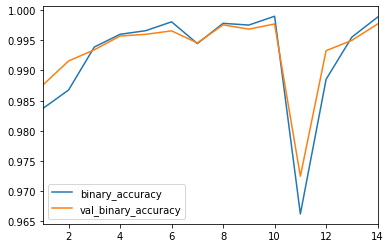

In [36]:
learner.show_history('acc', skip=1)